# Coverage of EP full-text dataset

## Table of contents:
    
* [Introduction](#Introduction)
* [1. Load data](#1.-Load-data)
* [2. Data processing](#2.-Data-processing)
* [3. Assess data coverage](#3.-Assess-data-coverage)

## Introduction

- Coverage according to the EP: https://www.epo.org/searching-for-patents/technical/full-text-additions.html

* [ ] The problem may come from the dataset containing the full text data!
* [ ] Plot an estimation of the availability of the claims of European patents according to the number of citations 

In [366]:
import pandas as pd
import warnings

In [367]:
# show all columns in pandas
pd.set_option('display.max_columns', 500)
# disable warnings
warnings.filterwarnings("ignore")

In [368]:
# location of the PATSTAT data previously retrieved with the data_extraction_from_PATSTAT.ipynb notebook
output_files_prefix = "wind_tech_1990_2020_with_publications"
pre = '../data/raw/' + output_files_prefix
suf = '.csv'

## 1. Load data

In [445]:
# for convenience, we store all the data retrieved into a single data object.
data = {'_table_main_patent_infos': pd.read_csv(pre + '_table_main_patent_infos' + suf, low_memory=False),
       '_table_cpc': pd.read_csv(pre + '_table_cpc' + suf, low_memory=False), 
       '_table_patentees_info': pd.read_csv(pre + '_table_patentees_info' + suf, low_memory=False),
       '_table_backward_docdb_citations': pd.read_csv(pre + '_table_backward_docdb_citations' + suf, low_memory=False),
       '_table_forward_docdb_citations': pd.read_csv(pre + '_table_forward_docdb_citations' + suf, low_memory=False),
       '_text_data':pd.read_csv('../data/raw/wind_tech_1990_2020_with_publications_full_text.csv', sep = ',')}

In [446]:
def filter_EP_patents(data):
    """We filter the _table_main_patent_infos dataset to keep only EP patents"""
    data['_table_main_patent_infos'] = data['_table_main_patent_infos'][data['_table_main_patent_infos']['appln_auth']=='EP']
    return data

In [451]:
def select_columns(data):
    """We remove the columns called 'index' as they are unuseful and perturb the merge"""
    cols = ['appln_id',
            'appln_auth',
            'appln_nr',
            'appln_kind',
            'appln_filing_date',
            'appln_filing_year',
            'appln_nr_epodoc',
            'appln_nr_original',
            'ipr_type',
            'receiving_office',
            'internat_appln_id',
            'int_phase',
            'reg_phase',
            'nat_phase',
            'earliest_filing_date',
            'earliest_filing_year',
            'earliest_filing_id',
            'earliest_publn_date',
            'earliest_publn_year',
            'earliest_pat_publn_id',
            'granted',
            'docdb_family_id',
            'inpadoc_family_id',
            'docdb_family_size',
            'nb_citing_docdb_fam',
            'nb_applicants',
            'nb_inventors',
            'appln_title_lg',
            'appln_title',
            'appln_abstract_lg',
            'appln_abstract',
            'ipc_class_symbol',
            'ipc_class_level',
            'ipc_version',
            'ipc_value',
            'ipc_position',
            'ipc_gener_auth',
            'nace2_code',
            'weight',
            'pat_publn_id',
            'publn_auth',
            'publn_nr',
            'publn_nr_original',
            'publn_kind',
            'publn_date',
            'publn_lg',
            'publn_first_grant',
            'publn_claims']
    
    data['_table_main_patent_infos'] = data['_table_main_patent_infos'][cols]
    
    cols = ['appln_id',
            'person_id',
            'applt_seq_nr',
            'invt_seq_nr',
            'person_name',
            'person_address',
            'person_ctry_code',
            'doc_std_name_id',
            'doc_std_name',
            'psn_id',
            'psn_name',
            'psn_level',
            'psn_sector',
            'person_orig_id',
            'source',
            'source_version',
            'name_freeform',
            'last_name',
            'first_name',
            'middle_name',
            'address_freeform',
            'address_1',
            'address_2',
            'address_3',
            'address_4',
            'address_5',
            'street',
            'city',
            'zip_code',
            'state',
            'residence_ctry_code',
            'role']
    data['_table_patentees_info'] = data['_table_patentees_info'][cols]
    return data

In [452]:
data = filter_EP_patents(data)
data = select_columns(data)

In [453]:
# we check the content of the filtered dataset
data['_table_main_patent_infos']['appln_auth'].value_counts()

EP    83839
Name: appln_auth, dtype: int64

In [468]:
df = pd.merge(left = data['_table_main_patent_infos'],
              right = data['_table_patentees_info'],
              on='appln_id')
df.head()

,appln_id,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_epodoc,appln_nr_original,ipr_type,receiving_office,internat_appln_id,int_phase,reg_phase,nat_phase,earliest_filing_date,earliest_filing_year,earliest_filing_id,earliest_publn_date,earliest_publn_year,earliest_pat_publn_id,granted,docdb_family_id,inpadoc_family_id,docdb_family_size,nb_citing_docdb_fam,nb_applicants,nb_inventors,appln_title_lg,appln_title,appln_abstract_lg,appln_abstract,ipc_class_symbol,ipc_class_level,ipc_version,ipc_value,ipc_position,ipc_gener_auth,nace2_code,weight,pat_publn_id,publn_auth,publn_nr,publn_nr_original,publn_kind,publn_date,publn_lg,publn_first_grant,publn_claims,person_id,applt_seq_nr,invt_seq_nr,person_name,person_address,person_ctry_code,doc_std_name_id,doc_std_name,psn_id,psn_name,psn_level,psn_sector,person_orig_id,source,source_version,name_freeform,last_name,first_name,middle_name,address_freeform,address_1,address_2,address_3,address_4,address_5,street,city,zip_code,state,residence_ctry_code,role
0,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,1892412,NaN,A1,2008-02-27,de,0,7,539.0,1.0,0.0,Nordex Energy GmbH,"Bornbarch 2,22848 Norderstedt",DE,488.0,NORDEX ENERGY GMBH,20847805.0,NORDEX ENERGY,1.0,COMPANY,541.0,EPREG,NaN,Nordex Energy GmbH,NaN,NaN,NaN,NaN,Bornbarch 2,22848 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN
1,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,1892412,NaN,A1,2008-02-27,de,0,7,539.0,1.0,0.0,Nordex Energy GmbH,"Bornbarch 2,22848 Norderstedt",DE,488.0,NORDEX ENERGY GMBH,20847805.0,NORDEX ENERGY,1.0,COMPANY,143475.0,EPREG,NaN,NORDEX ENERGY GmbH,NaN,NaN,NaN,NaN,Bornbarch 2,22848 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN
2,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,1892412,NaN,A1,2008-02-27,de,0,7,539.0,1.0,0.0,Nordex Energy GmbH,"Bornbarch 2,22848 Norderstedt",DE,488.0,NORDEX ENERGY GMBH,20847805.0,NORDEX ENERGY,1.0,COMPANY,785202.0,EPREG,NaN,NORDEX Energy GmbH,NaN,NaN,NaN,NaN,Bornbarch 2,22848 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN
3,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,1892412,NaN,A1,2008-02-27,de,0,7,542.0,0.0,3.0,"Jurkat, Mark","Schinkelring 146,22846 Norderstedt",DE,491.0,JURKAT MARK,13950032.0,"JURKAT, MARK",0.0,NaN,544.0,EPREG,NaN,"Jurkat, Mark",NaN,NaN,NaN,NaN,Schinkelring 146,22846 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN
4,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,1892412,NaN,A1,2008-02-27,de,0,7,540.0,0.0,1.0,"Richter, Kay","Heidbergstrasse 71,22846 Norderstedt",DE,489.0,RICHTER KAY,23764765.0,"RICHTER, KAY",0.0,NaN,60571757.0,EPREG,NaN,"Richter, Kay",NaN,NaN,NaN,NaN,Heidbergstraße 71,22846 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN


In [475]:
data['_table_main_patent_infos'] = df

## 2. Data processing

In [476]:
def reshape_PATSTAT_data(data):
    """ Reshaping PATSTAT data """
    
    # retrieve variables of interest from the PATSTAT dataset
    cols = ['appln_id','appln_filing_year','appln_auth','publn_auth',
            'publn_nr','publn_nr_original','publn_lg']
    #table_PATSTAT = data['_table_main_patent_infos'][cols]

    # drop duplicates
    #table_PATSTAT.drop_duplicates(inplace = True)
    
    table_PATSTAT = data['_table_main_patent_infos']
    cols = [col for col in list(table_PATSTAT) if col != 'publn_nr' and col != 'publn_nr_original']
    
    # we place old and new publication numbers in the same columns (wide to long reshape)
    #table_PATSTAT = pd.melt(table_PATSTAT,
    #                        id_vars=['appln_id', 'appln_filing_year','appln_auth', 'publn_auth',
    #                                 'publn_lg'],
    #                        var_name='type_publication_nb',
    #                        value_name='publn_nr')
    
    table_PATSTAT = pd.melt(table_PATSTAT,
                            id_vars=cols,
                            var_name='type_publication_nb',
                            value_name='publn_nr')
    return table_PATSTAT

In [477]:
def reshape_EP_full_text_data(data):
    """ Reshapes the EP full text data to be able to assess the wether a PATSTAT patent is present
    in the database """
    
    # retrieve variables of interest from the EP full text data
    table_EP_full_text = data['_text_data']
    # renaming the publication number column to align with PATSTAT before merging
    table_EP_full_text.rename(columns={'publication_number':  'publn_nr'}, inplace = True)
    # keep only patent which contains claims
    condition = table_EP_full_text['text_type'] == 'CLAIM'
    table_EP_full_text = table_EP_full_text[condition]
    # drop duplicates and keep only 2 variables
    table_EP_full_text = table_EP_full_text[['publn_nr', 'text_type']]
    table_EP_full_text.drop_duplicates(inplace = True)
    # store the ids as str
    table_EP_full_text['publn_nr'] = table_EP_full_text['publn_nr'].astype(str)
    return table_EP_full_text

In [478]:
def add_citations(data, table_PATSTAT):
    
    df = data['_table_main_patent_infos']
    mapp = dict(zip(df['appln_id'],df['nb_citing_docdb_fam']))
    table_PATSTAT['nb_citing_docdb_fam'] = table_PATSTAT['appln_id'].map(mapp)
    return table_PATSTAT

In [479]:
table_PATSTAT = reshape_PATSTAT_data(data)
table_PATSTAT = add_citations(data, table_PATSTAT)
table_PATSTAT.head()

,appln_id,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_epodoc,appln_nr_original,ipr_type,receiving_office,internat_appln_id,int_phase,reg_phase,nat_phase,earliest_filing_date,earliest_filing_year,earliest_filing_id,earliest_publn_date,earliest_publn_year,earliest_pat_publn_id,granted,docdb_family_id,inpadoc_family_id,docdb_family_size,nb_citing_docdb_fam,nb_applicants,nb_inventors,appln_title_lg,appln_title,appln_abstract_lg,appln_abstract,ipc_class_symbol,ipc_class_level,ipc_version,ipc_value,ipc_position,ipc_gener_auth,nace2_code,weight,pat_publn_id,publn_auth,publn_kind,publn_date,publn_lg,publn_first_grant,publn_claims,person_id,applt_seq_nr,invt_seq_nr,person_name,person_address,person_ctry_code,doc_std_name_id,doc_std_name,psn_id,psn_name,psn_level,psn_sector,person_orig_id,source,source_version,name_freeform,last_name,first_name,middle_name,address_freeform,address_1,address_2,address_3,address_4,address_5,street,city,zip_code,state,residence_ctry_code,role,type_publication_nb,publn_nr
0,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,A1,2008-02-27,de,0,7,539.0,1.0,0.0,Nordex Energy GmbH,"Bornbarch 2,22848 Norderstedt",DE,488.0,NORDEX ENERGY GMBH,20847805.0,NORDEX ENERGY,1.0,COMPANY,541.0,EPREG,NaN,Nordex Energy GmbH,NaN,NaN,NaN,NaN,Bornbarch 2,22848 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr,1892412
1,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,A1,2008-02-27,de,0,7,539.0,1.0,0.0,Nordex Energy GmbH,"Bornbarch 2,22848 Norderstedt",DE,488.0,NORDEX ENERGY GMBH,20847805.0,NORDEX ENERGY,1.0,COMPANY,143475.0,EPREG,NaN,NORDEX ENERGY GmbH,NaN,NaN,NaN,NaN,Bornbarch 2,22848 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr,1892412
2,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,A1,2008-02-27,de,0,7,539.0,1.0,0.0,Nordex Energy GmbH,"Bornbarch 2,22848 Norderstedt",DE,488.0,NORDEX ENERGY GMBH,20847805.0,NORDEX ENERGY,1.0,COMPANY,785202.0,EPREG,NaN,NORDEX Energy GmbH,NaN,NaN,NaN,NaN,Bornbarch 2,22848 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr,1892412
3,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,A1,2008-02-27,de,0,7,542.0,0.0,3.0,"Jurkat, Mark","Schinkelring 146,22846 Norderstedt",DE,491.0,JURKAT MARK,13950032.0,"JURKAT, MARK",0.0,NaN,544.0,EPREG,NaN,"Jurkat, Mark",NaN,NaN,NaN,NaN,Schinkelring 146,22846 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr,1892412
4,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,A1,2008-02-27,de,0,7,540.0,0.0,1.0,"Richter, Kay","Heidbergstrasse 71,22846 Norderstedt",DE,489.0,RICHTER KAY,23764765.0,"RICHTER, KAY",0.0,NaN,60571757.0,EPREG,NaN,"Richter, Kay",NaN,NaN,NaN,NaN,Heidbergstraße 71,22846 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr,1892412


In [480]:
table_PATSTAT['type_publication_nb'].value_counts()

publn_nr_original    360387
publn_nr             360387
Name: type_publication_nb, dtype: int64

In [481]:
table_EP_full_text = reshape_EP_full_text_data(data)
table_EP_full_text.head()

,publn_nr,text_type
5,92,CLAIM
12,415,CLAIM
19,872,CLAIM
26,1611,CLAIM
33,1874,CLAIM


## 3. Assess data coverage

In [482]:
# merging the two datasets 
mapp = dict(zip(table_EP_full_text['publn_nr'],table_EP_full_text['text_type']))
table_PATSTAT['claims_availability'] = table_PATSTAT['publn_nr'].map(mapp).fillna('No')
mapp = {}
mapp['CLAIM'] = 'Yes'
table_PATSTAT['claims_availability'] = table_PATSTAT['claims_availability'].map(mapp).fillna(table_PATSTAT['claims_availability'])
# if we have a claim, we drop duplicates for the other (unmatched) publication numbers
table_PATSTAT.sort_values(by = 'claims_availability', ascending = False, inplace = True)
table_PATSTAT.drop_duplicates(subset = 'appln_id', inplace = True)

In [483]:
table_PATSTAT.head()

,appln_id,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_epodoc,appln_nr_original,ipr_type,receiving_office,internat_appln_id,int_phase,reg_phase,nat_phase,earliest_filing_date,earliest_filing_year,earliest_filing_id,earliest_publn_date,earliest_publn_year,earliest_pat_publn_id,granted,docdb_family_id,inpadoc_family_id,docdb_family_size,nb_citing_docdb_fam,nb_applicants,nb_inventors,appln_title_lg,appln_title,appln_abstract_lg,appln_abstract,ipc_class_symbol,ipc_class_level,ipc_version,ipc_value,ipc_position,ipc_gener_auth,nace2_code,weight,pat_publn_id,publn_auth,publn_kind,publn_date,publn_lg,publn_first_grant,publn_claims,person_id,applt_seq_nr,invt_seq_nr,person_name,person_address,person_ctry_code,doc_std_name_id,doc_std_name,psn_id,psn_name,psn_level,psn_sector,person_orig_id,source,source_version,name_freeform,last_name,first_name,middle_name,address_freeform,address_1,address_2,address_3,address_4,address_5,street,city,zip_code,state,residence_ctry_code,role,type_publication_nb,publn_nr,claims_availability
0,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,en,Method for operating wind farms,en,The method involves defining an idle power int...,H02J 3/18,A,2006-01-01,I,L,EP,27.12,0.333333,278556884,EP,A1,2008-02-27,de,0,7,539.0,1.0,0.0,Nordex Energy GmbH,"Bornbarch 2,22848 Norderstedt",DE,488.0,NORDEX ENERGY GMBH,20847805.0,NORDEX ENERGY,1.0,COMPANY,541.0,EPREG,NaN,Nordex Energy GmbH,NaN,NaN,NaN,NaN,Bornbarch 2,22848 Norderstedt,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr,1892412,Yes
435712,16425056,EP,08156481,A,2008-05-19,2008,EP20080156481,08156481,PI,,0,N,Y,N,2007-05-25,2007,55388813,2008-11-26,2008,55213104,1,39711963,4784165,3,60,1,6,en,Protective circuit and method for multi-level ...,en,A protective circuit (10) for a multi-level co...,H02H 7/12,A,2006-01-01,I,L,EP,27.90,0.666667,469708654,EP,B1,2016-10-26,en,1,10,2211376.0,0.0,5.0,"Roesner, Robert","Georgenstrasse 144,D-80797 München",DE,1119690.0,ROESNER ROBERT,24083192.0,"ROESNER, ROBERT",0.0,NaN,2285757.0,EPREG,NaN,"Roesner, Robert",NaN,NaN,NaN,NaN,Georgenstrasse 144,D-80797 München,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr_original,1995860,Yes
443461,17453882,EP,99963451,A,1999-12-09,1999,EP19990963451,99963451,PI,,15705609,Y,Y,N,1998-12-09,1998,13748054,2001-10-10,2001,292889450,1,27438969,357797,29,72,1,1,en,ROTOR BLADE OF A WIND TURBINE,NaN,NaN,F03D 11/00,A,2006-01-01,I,L,EP,28.90,0.200000,411395516,EP,B2,2013-11-20,de,0,3,2327.0,1.0,1.0,"Wobben, Aloys","Argestrasse 19,26607 Aurich",DE,1963.0,WOBBEN ALOYS,7016977.0,ENERCON (ALOYS WOBBEN),2.0,COMPANY,60571368.0,EPREG,NaN,"Wobben, Aloys",NaN,NaN,NaN,NaN,Argestraße 19,26607 Aurich,NaN,NaN,NaN,NaN,NaN,NaN,,,NaN,publn_nr_original,1141543,Yes
442337,17427715,EP,99920647,A,1999-04-13,1999,EP19990920647,99920647,PI,,15698579,Y,Y,N,1998-04-14,1998,13513840,2001-01-31,2001,293506599,1,7864471,1002334,18,35,1,1,en,WIND POWER PLANT WITH A TRANSFORMER,NaN,NaN,F03D 80/80,A,2016-01-01,I,F,EP,28.10,1.000000,478766475,EP,B2,2017-06-21,de,0,1,2327.0,1.0,1.0,"Wobben, Aloys","Argestrasse 19,26607 Aurich",DE,1963.0,WOBBEN ALOYS,7016977.0,ENERCON (ALOYS WOBBEN),2.0,COMPANY,8074233.0,USPTO,BACKFILE,NaN,Wobben,Aloys,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Argestrasse 19,26607 Aurich,NaN,,DE,NaN,publn_nr_original,1071883,Yes
443736,54938871,EP,07722543,A,2007-03-19,2007,EP20070722543,07722543,PI,,15564815,Y,Y,N,2006-03-17,2006,901973033,2008-12-03,2008,278059329,1,38222469,1638494,9,17,1,4,en,WIND TURBINE WITH A PROTECTION SYSTEM FOR AN E...,NaN,NaN,H02J 3/38,A,2006-01-01,I,L,EP,27.12,0.400000,405879705,EP,B1,2013-04-24,en,1,16,4077469.0,0.0,2.0,"NIEUWENHUIZEN, John, Johannes Mathias, Hubertus","Kirkeskovvej 21,DK-8700 Horsens",DK,1760962.0,NIEUWENHUIZEN JOHN JOHANNES MATHIAS HUBERTUS,20599944.0,"NIEUWENHUIZEN, JOHN, JOHANNES MATHIAS, HUBERTUS",0.0,NaN,4200388.0,EPREG,NaN,"NIEUWENHUIZEN, John, Johannes Mathias, Hubertus",NaN,NaN

In [484]:
import matplotlib.pyplot as plt
# use the 'seaborn-colorblind' style
plt.style.use('seaborn-paper')
sns.set(rc={'figure.figsize':(16,4)})

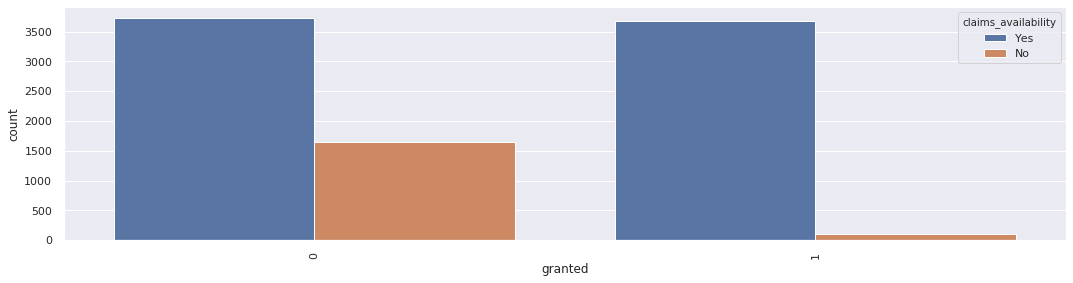

In [491]:
# data availability for EP patents
import seaborn as sns
df = table_PATSTAT[table_PATSTAT['appln_auth']=='EP']

# data availability according to patent authority
g = sns.countplot(x='granted', hue='claims_availability', data=table_PATSTAT)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

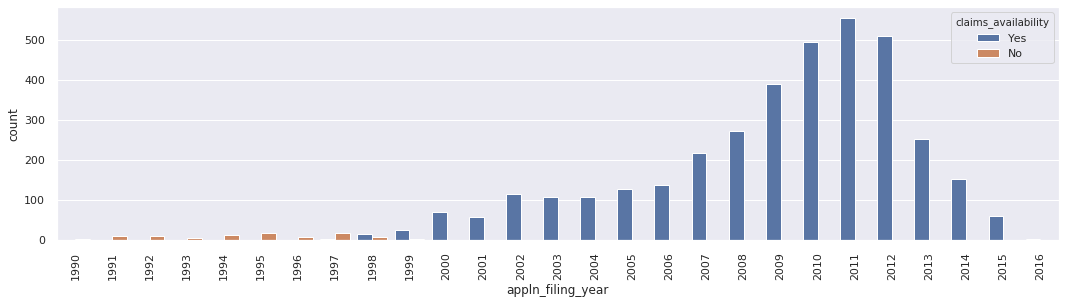

In [492]:
# and when we keep only granted patents!
df = df[df['granted']==1]
g = sns.countplot(x='appln_filing_year', hue='claims_availability', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

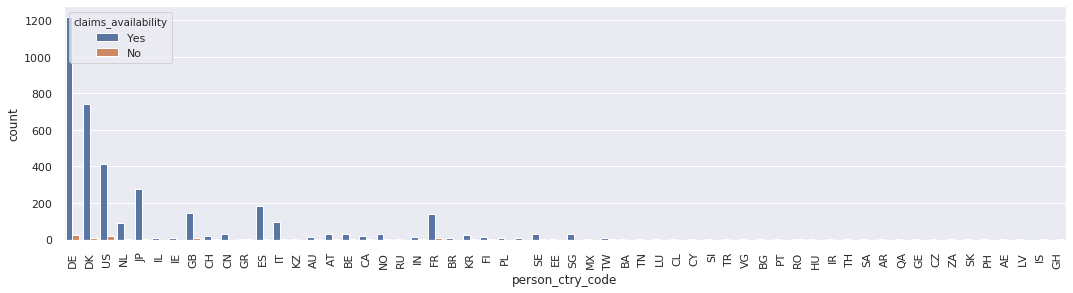

In [489]:
# By country of origin 
df = table_PATSTAT[table_PATSTAT['granted']==1]
# data availability according to patent authority
g = sns.countplot(x='person_ctry_code', hue='claims_availability', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

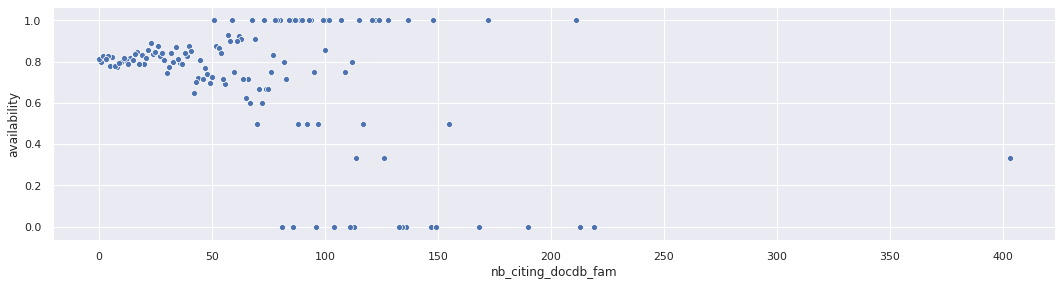

In [403]:
d = []

EP_data = table_PATSTAT[table_PATSTAT['appln_auth']=='EP']
index = EP_data['nb_citing_docdb_fam'].unique().tolist()

for i in index:
    df = EP_data[EP_data['nb_citing_docdb_fam']==i]
    y = len(df[df['claims_availability']=='Yes'])
    n = len(df[df['claims_availability']=='No'])
    availability = y/(y+n)
    
    d.append(
        {
            'nb_citing_docdb_fam': i,
            'availability': availability
        })
    

df = pd.DataFrame(d)

g = sns.scatterplot(x='nb_citing_docdb_fam', y='availability', data=df)

In [ ]:
# plot an estimation of the availability of the claims of European patents 
# according to the number of citations 

In [ ]:
g = sns.regplot(x='nb_citing_docdb_fam', y='claims_availability', data=table_PATSTAT)
g.set_xticklabels(g.get_xticklabels(), rotation=90);